# Volatility smile

## Recall BSM formula

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import scipy.optimize as so

In [2]:
'''============
Gbm class inherited from sde_1d
Usage:
    gbm1 = Gbm(init_state = 100., drift_ratio=.05, vol_ratio=.2)
============='''

class Gbm:
    def __init__(self,
                 init_state = 100.,
                 drift_ratio = .0475,
                 vol_ratio = .2
                ):
        self.init_state = init_state
        self.drift_ratio = drift_ratio
        self.vol_ratio = vol_ratio
        
        

In [3]:
'''=========
option class init
Usage:
    option1 = EuropeanOption(otype = 1, strike = 100., maturity = 1/12)
=========='''
class EuropeanOption:
    def __init__(self,
                otype = 1, # 1: 'call'
                        # -1: 'put'
                strike = 110.,
                maturity = 1.
                ):
        self.otype = otype
        self.strike = strike
        self.maturity = maturity
        
    def payoff(self, s): #s: excercise price
        otype = self.otype
        k = self.strike
        maturity = self.maturity
        return np.max([0, (s - k)*otype])
        

In [4]:
'''========
Black-Scholes-Merton formula. 
=========='''

def bsm_price(self, european_option):
    s0 = self.init_state
    sigma = self.vol_ratio
    r = self.drift_ratio
    
    otype = european_option.otype
    k = european_option.strike
    maturity = european_option.maturity
    
    d1 = (np.log(s0 / k) + (r + 0.5 * sigma ** 2) 
          * maturity) / (sigma * np.sqrt(maturity))
    d2 = d1 - sigma * np.sqrt(maturity)
    
    return otype * s0 * ss.norm.cdf(otype * d1) - otype * np.exp(-r * maturity) * k * ss.norm.cdf(otype * d2)

Gbm.bsm_price = bsm_price

In [5]:
'''===============
Test bsm_price
================='''
gbm1 = Gbm()
option1 = EuropeanOption()
print('>>>>>>>call value is ' + str(gbm1.bsm_price(option1)))
option2 = EuropeanOption(otype=-1)
print('>>>>>>>>put value is ' + str(gbm1.bsm_price(option2)))


>>>>>>>call value is 5.943273183452838
>>>>>>>>put value is 10.84042522804176


## Calibration

In [6]:
'''======
Read data
========='''
#Read four-column data
#columns are otype, maturity, strike, option_price
np_option_data1 = np.loadtxt('optiondata2.dat', comments='#', delimiter=',')

print('>>>>>>otype, maturity, strike, option_price')
print(np_option_data1)

>>>>>>otype, maturity, strike, option_price
[[  1.           0.16666667  97.           5.32705461]
 [  1.           0.16666667  99.           3.86224255]
 [  1.           0.16666667 101.           2.7204371 ]
 [  1.           0.16666667 103.           2.1202793 ]
 [  1.           0.41666667  97.           7.23756307]
 [  1.           0.41666667  99.           5.95053461]
 [  1.           0.41666667 101.           5.2640122 ]
 [  1.           0.41666667 103.           4.97493422]]


In [7]:
def bsm_calibration(spot_price, interest_rate, option_array):
    init_vol = .1 #initial guess
    gbm1 = Gbm(spot_price, interest_rate, init_vol)
    
    def error_function(vol):
        gbm1.vol_ratio = vol
        error_sum = 0.
        for i in range(option_array.shape[0]):
            option1 = EuropeanOption(otype = option_array[i,0],
                                     maturity = option_array[i,1],
                                     strike = option_array[i,2]
                                    )           
            error_sum = error_sum + (option_array[i, 3] - gbm1.bsm_price(option1))**2
            
        return error_sum
    return so.fmin(error_function, 0.1, disp = False)[0]

In [10]:
filter1 = np_option_data1[np_option_data1[:,1] == 2/12]
calibrated_volatility1 = bsm_calibration(100, .05, filter1)
print('>>>>>>>> calibrated_volatility is ' + str(calibrated_volatility1))

>>>>>>>> calibrated_volatility is 0.18109375000000028


[[  1.           0.16666667  97.           5.32705461   5.18422182]
 [  1.           0.16666667  99.           3.86224255   3.92251212]
 [  1.           0.16666667 101.           2.7204371    2.87093337]
 [  1.           0.16666667 103.           2.1202793    2.02970051]]


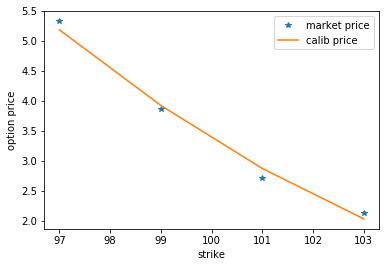

In [27]:
gbm1 = Gbm(100., .05, calibrated_volatility1)
#add a column for calibrated option price
filter1_calibrated = np.append(filter1, np.zeros([filter1.shape[0],1]), axis = 1)
for i in range(filter1.shape[0]):
    option1 = EuropeanOption(otype = filter1[i,0],
                             maturity = filter1[i,1],
                             strike = filter1[i,2]
                            )           
    filter1_calibrated[i, 4] = gbm1.bsm_price(option1)
print(filter1_calibrated)
plt.plot(filter1_calibrated[:,2], filter1_calibrated[:,3], '*', label='market price')
plt.plot(filter1_calibrated[:,2], filter1_calibrated[:,4], label = 'calib price')
plt.ylabel('option price')
plt.xlabel('strike with fixed 2-mon maturity')
plt.legend()
plt.show()

In [28]:
filter1 = np_option_data1[np_option_data1[:,1] == 5/12]
bsm_calibration(100, .05, filter1)

0.1839843750000003

[[  1.           0.41666667  97.           7.23756307   7.47422428]
 [  1.           0.41666667  99.           5.95053461   6.2695818 ]
 [  1.           0.41666667 101.           5.2640122    5.19683024]
 [  1.           0.41666667 103.           4.97493422   4.25606294]]


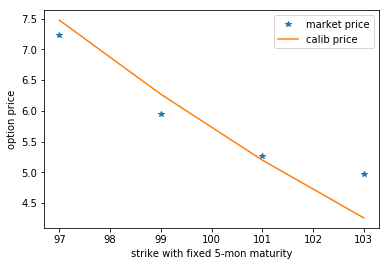

In [30]:
gbm1 = Gbm(100., .05, calibrated_volatility1)
#add a column for calibrated option price
filter1_calibrated = np.append(filter1, np.zeros([filter1.shape[0],1]), axis = 1)
for i in range(filter1.shape[0]):
    option1 = EuropeanOption(otype = filter1[i,0],
                             maturity = filter1[i,1],
                             strike = filter1[i,2]
                            )           
    filter1_calibrated[i, 4] = gbm1.bsm_price(option1)
print(filter1_calibrated)
plt.plot(filter1_calibrated[:,2], filter1_calibrated[:,3], '*', label='market price')
plt.plot(filter1_calibrated[:,2], filter1_calibrated[:,4], label = 'calib price')
plt.ylabel('option price')
plt.xlabel('strike with fixed 5-mon maturity')
plt.legend()
plt.show()